In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time
import sympy
np.set_printoptions(precision=3)

In [2]:
## Setup a model params

M = 2                # the population has two age groups
N = 5e4              # and this is the total population
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi
# set the contact structure
C = np.array([[18., 9.], 
              [3., 12.]]) 
def contactMatrix(t):
    return C

steps=101
t1, t2 = 0, 5
Nf=steps

time_points=np.linspace(0, t2-t1, steps)
dt = time_points[1]-time_points[0]

## Inital From Gunther
alpha = 0.20952031
beta = 0.2008036 
gIa =0.14791327  
gIs = 0.14231912
fsa = 1
#parameters = {'alpha': alpha, 'beta': beta, 'gIa':gIa, 'gIs':gIs, 'fsa':fsa}
x0 = np.array([2.496e-01, 7.496e-01, 2.000e-04, 2.000e-04, 2.000e-04, 2.000e-04])*N


### Set up model spec
inference_parameters = {
    'betaIa' : beta*alpha, 
    'betaIs' : beta*(1-alpha), 
    'gIa' : gIa, 
    'gIs' : gIs
}
model_spec = {
    "classes" : ["S", "Ia", "Is"],

    "S" : {
        "linear"    : [],
        "infection" : [ ["Ia", "-betaIa"], ["Is", "-betaIa"], ["Ia", "-betaIs"], ["Is", "-betaIs"]]
    },
    "Ia" : {
        "linear"    : [ ["Ia", "-gIa"] ],
        "infection" : [ ["Ia", "betaIa"], ["Is", "betaIa"] ]
    }, 
    "Is" :{
        "linear"    : [ ["Is", "-gIs"] ],
        "infection" : [ ["Is", "betaIs"], ["Ia", "betaIs"]]
    }
}


In [3]:
# initialise the estimator 
nClass = len(model_spec['classes'])
nParams = len(inference_parameters)
estimator = pyross.inference.Spp(model_spec, inference_parameters, M, Ni)
estimator.set_det_model(inference_parameters)
estimator.set_contact_matrix(contactMatrix)

xm, sol = estimator.integrate(x0, t1, t2, Nf, dense_output=True)

## Tests of the gradient computations

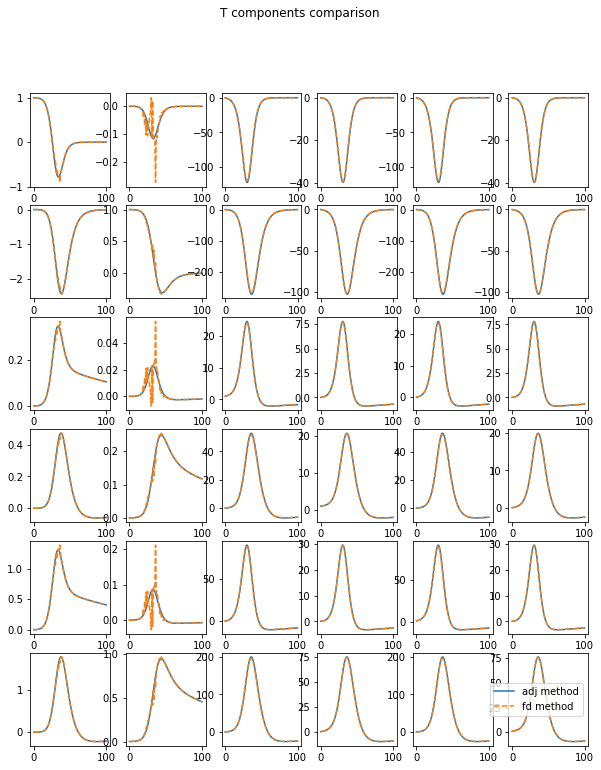

In [4]:
##################### TEST 1 : Time evol Op ####################################
estimator.set_lyapunov_method('LSODA')

xd, sol = estimator.integrate(x0, t1, t2, Nf, dense_output=True)
T1 = np.zeros( (steps, M*nClass, M*nClass))
T2 = np.zeros( (steps, M*nClass, M*nClass))
for k,ts in enumerate(time_points+dt):
    xf=xd[k]
    estimator._obtain_time_evol_op(sol, t1, ts)
    T1[k,:,:] = estimator.U
    estimator._obtain_time_evol_op_2(sol, t1, ts)
    T2[k,:,:] = estimator.U

fig, axs = plt.subplots(M*nClass,M*nClass, figsize=(10, 12))
axs = np.ndarray.flatten(axs)
for k,ax in enumerate(axs):
    kx = k //(M*nClass)
    ky = k % (M*nClass)
    ax.plot(T1[:,kx,ky], label="adj method")
    ax.plot(T2[:,kx,ky], '--', label="fd method")
plt.suptitle("T components comparison")
plt.legend()
plt.show()

In [5]:
################## TEST 2 : Sympy functions initialisation ################################
x =sympy.Matrix( sympy.symarray('x', (nClass, M)))
b=estimator.construct_B_spp(x)
a=estimator.construct_A_spp(x)
j=estimator.construct_J_spp(x)
p =sympy.Matrix( sympy.symarray('p', (nParams, M)))
#print(a,b,j)

In [69]:
################## TEST 3 : Derivatives of mean trajectories ################################
## NOTE: this is a bit slow
est_obj = pyross.inference.Spp(model_spec, inference_parameters, M, Ni)
est_obj.set_contact_matrix(contactMatrix)

def dtrajdp_FD(param_str, scale=1e5):
    """ Calculates deribvative of mean traj using finite difference (FD)"""
    Paramvalue = inference_parameters[param_str]
    dp = Paramvalue/scale

    inference_parameters[param_str] +=dp
    est_obj.set_params(inference_parameters)
    est_obj.set_det_model(inference_parameters)
    xd_p = est_obj.integrate(x0, t1, t2, Nf) 
    
    inference_parameters[param_str] -= 2*dp
    est_obj.set_params(inference_parameters)
    est_obj.set_det_model(inference_parameters)
    xd_m = est_obj.integrate(x0, t1, t2, Nf)

    inference_parameters[param_str] +=dp
    return xd_p, xd_m, dp

In [70]:
keys = np.ones((nParams,M), dtype=int)
estimator.set_det_model(inference_parameters)
nSamples=10
nBlock=steps//(nSamples-1)
dtraj = estimator.dmudp(x0, t1, t2, nSamples, rtol=1e-4)
print(dtraj.shape)

(9, 6, 8)


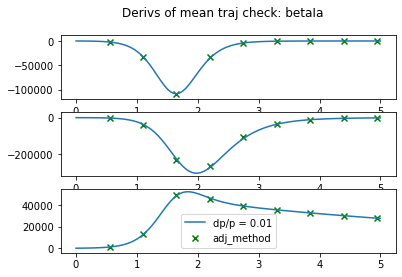

In [71]:
## Find derivatives wrt the params via finite difference
scale=1e2
xp, xm, dp = dtrajdp_FD('betaIa', scale=scale)
dxdp=(xp-xm)/(2*dp)

fig, axs = plt.subplots(nClass)
axs = np.ndarray.flatten(axs)
for k, axx in enumerate(axs):
    axx.plot(time_points, dxdp[:,k], label=f"dp/p = {1/scale}")
    axx.scatter(time_points[nBlock::nBlock], np.sum(dtraj[:, k, 0:2], axis=1), marker='x', color='green', label=f"adj_method")
plt.suptitle("Derivs of mean traj check: betaIa")
plt.legend()
plt.show()

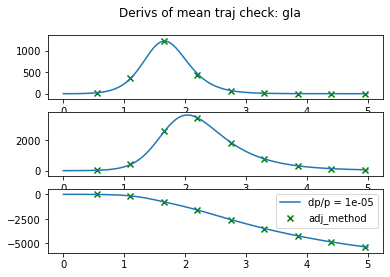

In [73]:
## Find derivatives wrt the params via finite difference
scale=1e5
xp, xm, dp = dtrajdp_FD('gIa', scale=scale)
dxdp=(xp-xm)/(2*dp)

fig, axs = plt.subplots(nClass)
axs = np.ndarray.flatten(axs)
for k, axx in enumerate(axs):
    axx.plot(time_points, dxdp[:,k], label=f"dp/p = {1/scale}")
    axx.scatter(time_points[nBlock::nBlock], np.sum(dtraj[:,k,4:6], axis=1), marker='x', color='green', label=f"adj_method")
plt.suptitle("Derivs of mean traj check: gIa")
plt.legend()
plt.show()

## Still working on the remaining cells 

In [ ]:
## Derivatives of invcov
# steps=21
# keys = np.ones((nParams,M), dtype=int)
# det_model=estimator.set_det_model(inference_parameters)
# dinvcovdp = estimator.dfullinvcovdp(x0, t1, t2, steps, contactMatrix)

In [ ]:
# a=dinvcovdp[4]
# plt.imshow(a[30:60, 30:60]) ## some block - verfifies block diag and symmetry